In [26]:
!pip install --user -r requirements.txt

In [9]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
from wettbewerb import load_references, get_3montages
import mne
from scipy import signal as sig
import ruptures as rpt

In [2]:
training_folder = "Y:/External Databases/TUH EEG Seizure Corpus/data_mat/test_mat_wki"

In [48]:
ids, channels, data, sampling_frequencies, reference_systems, eeg_labels = load_references(training_folder) # Importiere EKG-Dateien, zugehörige Diagnose, Sampling-Frequenz (Hz) und Name (meist fs=300 Hz)



117	 Dateien wurden geladen.


In [40]:
idx_record = 100
print("IDs[0:3]: ",ids[:3])
print("Verfügbare Kanäle:",channels[idx_record])
print("Abtastrate: ", sampling_frequencies[idx_record],"Hz")
print("Referenzsystem: ", reference_systems[idx_record])
print("EEG Labels: (seizure_present, onset, offset)", eeg_labels[idx_record])

IDs[0:3]:  ['aaaaasvq_s004_t000', 'aaaaasvq_s004_t001', 'aaaaasvq_s004_t002']
Verfügbare Kanäle: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
Abtastrate:  256 Hz
Referenzsystem:  AR
EEG Labels: (seizure_present, onset, offset) (1, 62.3997, 77.3393)


In [41]:
# Berechne Montagen der linken und rechten Gehirnhälfte für die erste Aufnahme
new_montage, new_data, is_missing = get_3montages(channels[idx_record], data[idx_record])
print("Alle Montagen wurden berechnet: ", not is_missing)
print("Montagen: ",new_montage)
print("Signal Dimension: ", new_data.shape)

Alle Montagen wurden berechnet:  True
Montagen:  ['Fp1-F3', 'Fp2-F4', 'C3-P3']
Signal Dimension:  (3, 25692)


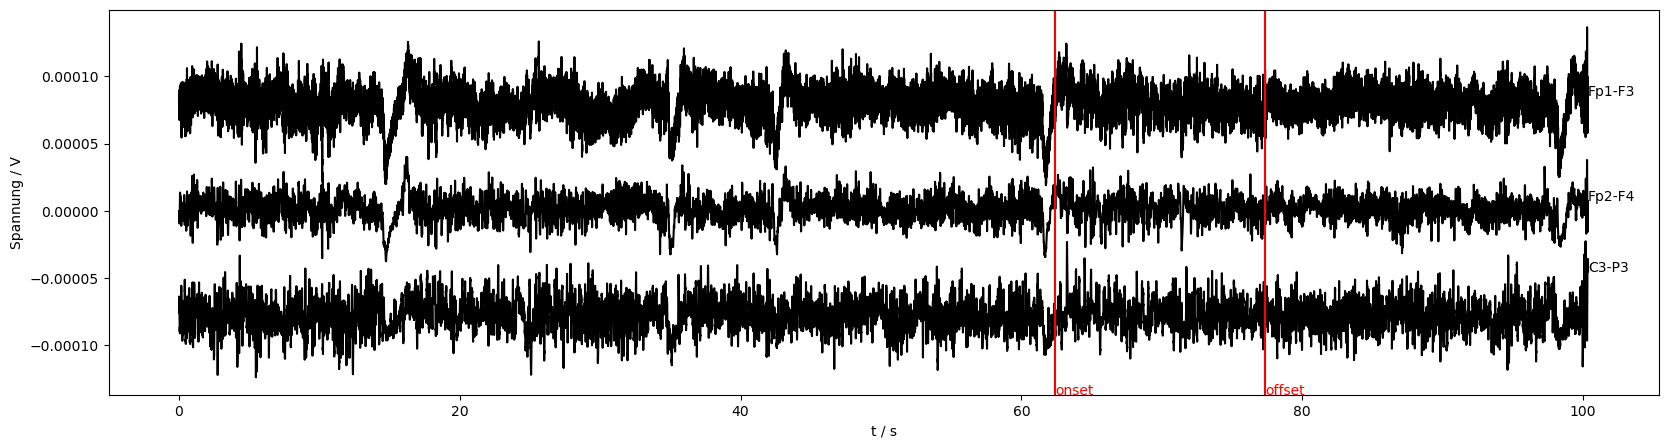

In [70]:
# Wir schauen die drei Montagen an
fig, axs = plt.subplots(figsize=[20,5])
max_diff=new_data.max()-new_data.min()
time_ax = np.arange(new_data.shape[1])/sampling_frequencies[idx_record]
_off_sets = [max_diff/1.5,0,-max_diff/1.5]
_labels = eeg_labels[idx_record]

for i, _montage in enumerate(new_montage):
    plt.plot(time_ax,new_data[i,:]+_off_sets[i],'k')
    plt.text(time_ax[-1], new_data[i,-1]+_off_sets[i], _montage)
if _labels[0]:
    plt.axvline(x = _labels[1], color = 'r', label = 'onset')
    plt.text(_labels[1], axs.get_ylim()[0], 'onset',color='r')  
    plt.axvline(x = _labels[2], color = 'r', label = 'offset')
    plt.text(_labels[2], axs.get_ylim()[0], 'offset',color='r')   
plt.xlabel("t / s")
plt.ylabel("Spannung / V")
plt.show()

In [75]:
onset_list_predict = []
onset_list = []
seizure_id_list = []

for i,_id in enumerate(ids):
    _fs = sampling_frequencies[i]
    _eeg_signals = data[i]
    _eeg_label = eeg_labels[i]
    if _eeg_label[0]:
        onset_list.append(_eeg_label[1])
        seizure_id_list.append(_id)
        # Berechne Montage
        _montage, _montage_data, _is_missing = get_3montages(channels[i], _eeg_signals)
        for j, signal_name in enumerate(_montage):
            # Get one channel of EEG
            signal = _montage_data[j]
            # Apply notch filter to cancel out supply frequency
            signal_notch = mne.filter.notch_filter(x=signal, Fs=_fs, freqs=np.array([50.,100.]), n_jobs=2, verbose=False)
            # Apply bandpass filter between 0.5Hz and 70Hz to remove some noise from the signal
            signal_filter = mne.filter.filter_data(data=signal_notch, sfreq=_fs, l_freq=0.5, h_freq=70.0, n_jobs=2, verbose=False)
            #Parameter erklären
            #Überkommentieren
            #Compute short time fourier transformation of the signal, signal_filterd = filtered signal of channel, fs = sampling frequency, nperseg = length of each segment
            # Output f= array of sample frequencies, t = array of segment times, Zxx = STFT of signal
            f, t, Zxx = sig.stft(signal_filter, _fs, nperseg=_fs * 3)
            # Calculate step size of frequency
            df = f[1] - f[0]
            #Compute energy of the parts based on real and imaginary values of STFT
            E_Zxx = np.sum(Zxx.real ** 2 + Zxx.imag ** 2, axis=0) * df

            # Check if new array per patient has been created
            if j == 0:
                # Initialize array with energy signal of first channel
                E_array = np.array(E_Zxx)
            else:
                # Append energy signal of channel to the array (stack it)
                E_array = np.vstack((E_array, np.array(E_Zxx)))

        #Sum up energy of all channels
        E_total = np.sum(E_array, axis=0)
        # Get the index for the time at which the energy is maximum
        max_index = E_total.argmax()

        # Compute changepoints of the summed up signal
        # Check if index is at the beginning of the signal (since we are choosing a changepoint before the maximum method will cuase an error in that case
        if max_index == 0:
            # In this case seizure onset is at the beginning of the signal
            onset_list_predict.append(0.0)
        else:
            # Compute changepoints of the signal with method from ruptures package
            # Setup linearly penalized segmentation method to detect changepoints in signal with rbf cost function
            algo = rpt.Pelt(model="rbf").fit(E_total)
            # Get sorted list of changepoints, pen = penalty value
            result = algo.predict(pen=10)
            #Indices are shifted by one so subtract one
            result1 = np.asarray(result) - 1
            # Get the changepoints before the maximum
            result_red = result1[result1 < max_index]
            # Check if changepoint was found
            if len(result_red)<1:
                # If no changepoint was found, seizure onset is likely to be close to maximum
                print('no element')
                onset_index = max_index
            else:
                # Choose the changepoint which is closest to the maximum = seizure Onset
                onset_index = result_red[-1]
            # Append seizure onset to list
            onset_list_predict.append(t[onset_index])

no element
no element
no element
no element
no element
no element
no element
no element
no element
no element
no element
no element
no element
no element
no element
no element
no element
no element
no element
no element
no element
no element
no element
no element
no element
no element
no element
no element
no element
no element
no element


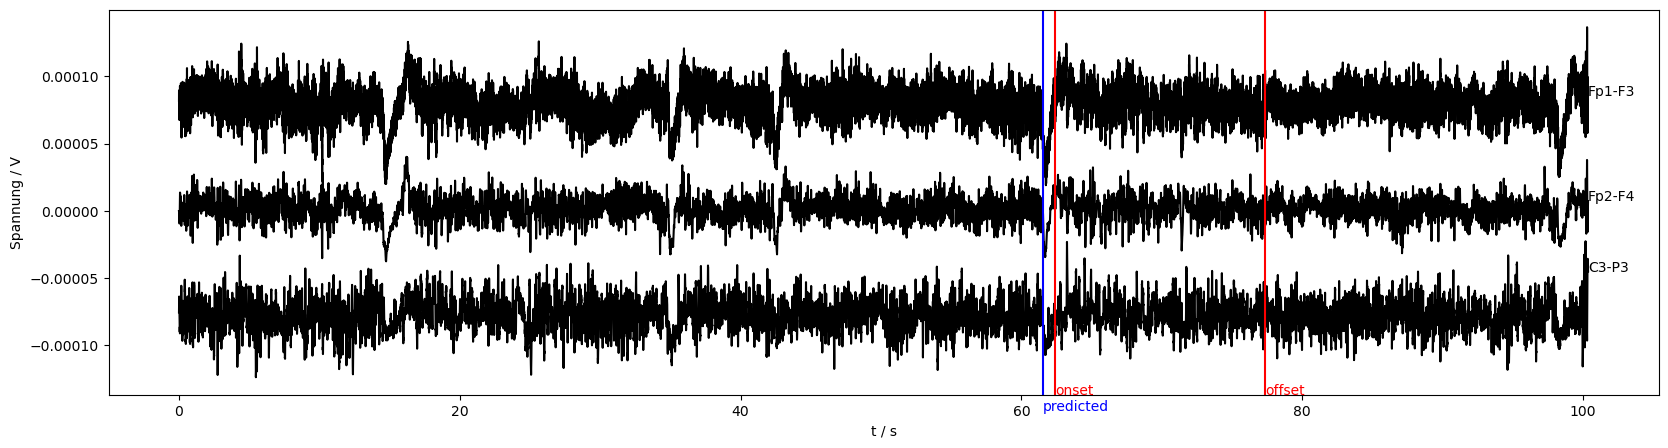

In [77]:
# Wir schauen das Ergebnis auf Basis der Montagen an
fig,axs = plt.subplots(figsize=[20,5])
max_diff=new_data.max()-new_data.min()
time_ax = np.arange(new_data.shape[1])/sampling_frequencies[idx_record]
_off_sets = [max_diff/1.5,0,-max_diff/1.5]
_labels = eeg_labels[idx_record]

for i, _montage in enumerate(new_montage):
    plt.plot(time_ax,new_data[i,:]+_off_sets[i],'k')
    plt.text(time_ax[-1], new_data[i,-1]+_off_sets[i], _montage)
if _labels[0]:
    pred_idx = seizure_id_list.index(ids[idx_record])
    plt.axvline(x = _labels[1], color = 'r', label = 'onset')
    plt.text(_labels[1], axs.get_ylim()[0], 'onset',color='r')  
    plt.axvline(x = _labels[2], color = 'r', label = 'offset')
    plt.text(_labels[2], axs.get_ylim()[0], 'offset',color='r')  
    plt.axvline(x = onset_list_predict[pred_idx], color = 'b', label = 'onset') 
    plt.text(onset_list_predict[pred_idx], axs.get_ylim()[0]-max_diff/10, 'predicted',color='b') 
plt.xlabel("t / s")
plt.ylabel("Spannung / V")
plt.show()

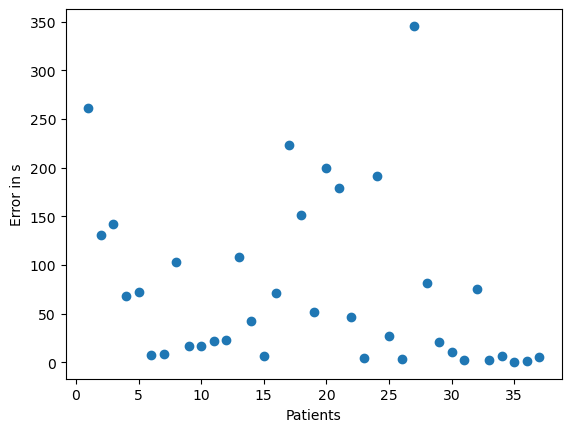

In [76]:


# Compute absolute error between compute seizure onset and real onset based on doctor annotations
prediction_error = np.abs(np.asarray(onset_list_predict) - np.asarray(onset_list))

# Plot error per patient
plt.figure(1)
plt.scatter(np.arange(1, len(prediction_error)+1),prediction_error)
#plt.hlines(10, 0, len(prediction_error)+1, colors='red')
plt.ylabel('Error in s')
plt.xlabel('Patients')
plt.show()